In [68]:
from zipfile import ZipFile
ZipFile("/content/Code&Data.zip").extractall("/content/")     #/drive/MyDrive

In [69]:
from scipy.io import loadmat
D = loadmat("/content/Code&Data/PIE.mat")

In [70]:
Data = D['Data']
Labels = D['Label']   

## Q1.a

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import time

train_Acc = []
test_Acc = []
running_time = []

# number of samples per training set = [5,10,15]
for i in range(5,16,5):

    n_sub = 21
    trainData = []
    testData = []
    trainLabels = []
    testLabels = []

    for j in range(1,68):
      trainData.append(Data[(j-1)*n_sub:(j-1)*n_sub+i])
      testData.append(Data[(j-1)*n_sub+i:j*n_sub])
      trainLabels.append(Labels[(j-1)*n_sub:(j-1)*n_sub+i])
      testLabels.append(Labels[(j-1)*n_sub+i:j*n_sub])

    # trainData, trainLabels of size number of samples * number of subjects
    trainData = np.array(trainData).reshape(len(trainData*i),900)
    testData = np.array(testData).reshape(len(testData*(n_sub-i)),900)
    trainLabels = np.array(trainLabels).reshape(len(trainLabels)*trainLabels[0].shape[0],1)
    testLabels = np.array(testLabels).reshape(len(testLabels)*testLabels[0].shape[0],1)


    start = time.time()

    # standardizing the dataset
    scaler = StandardScaler()
    data_scaled_train = scaler.fit_transform(trainData)
    data_scaled_test = scaler.transform(testData)

    # calculating covariance matrix and eigenvectors and eigen values
    cov_matrix = np.cov(data_scaled_train.T)
    values, vectors = np.linalg.eigh(cov_matrix)

    # sorting based on eigen values
    eig_pairs = [(np.abs(values[k]), vectors[:,k]) for k in range(len(values))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

    # transforming from deimension 900 to 100 using top eigen vectors
    pca_Transformed_train = data_scaled_train.dot(np.transpose(np.array([a[1] for a in eig_pairs[0:100]])))
    pca_Transformed_test = data_scaled_test.dot(np.transpose(np.array([a[1] for a in eig_pairs[0:100]])))

    # using knn classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(pca_Transformed_train,trainLabels)

    # recording train and test accuracies
    train_Acc.append(accuracy_score(trainLabels,knn.predict(pca_Transformed_train)))
    test_Acc.append(accuracy_score(testLabels,knn.predict(pca_Transformed_test)))
    end = time.time()

    # recoding running time
    running_time.append(end-start)

In [86]:
import pandas as pd
#summarizing train mse, test mse in a table
table = pd.DataFrame(list(zip(train_Acc,test_Acc,running_time)),columns = ["training mse using PCA","Testing mse using PCA","running time"])
table

,training mse using PCA,Testing mse using PCA,running time
0,0.877612,0.434701,0.318196
1,0.943284,0.500678,0.392914
2,0.981095,0.975124,0.434237


In [ ]:
i = 5
mean_vectors = []
sw = np.zeros((900,900))

train_Acc_lda = []
test_Acc_lda = []
running_time_lda = []

for i in range(5,16,5):
    n_sub = 21
    trainData = []
    testData = []
    trainLabels = []
    testLabels = []
    for j in range(1,68):
      trainData.append(Data[(j-1)*n_sub:(j-1)*n_sub+i])
      mean_vectors.append(np.mean(trainData[-1],axis = 0))

      # calculating with class scatter matrix sw
      sw+= (np.matrix(trainData[-1]-mean_vectors[-1]).T).dot(trainData[-1]-mean_vectors[-1])

      testData.append(Data[(j-1)*n_sub+i:j*n_sub])
      trainLabels.append(Labels[(j-1)*n_sub:(j-1)*n_sub+i])
      testLabels.append(Labels[(j-1)*n_sub+i:j*n_sub])
    # trainData, trainLabels of size number of samples * number of subjects
    trainData = np.array(trainData).reshape(len(trainData*i),900)
    testData = np.array(testData).reshape(len(testData*(n_sub-i)),900)
    trainLabels = np.array(trainLabels).reshape(len(trainLabels)*trainLabels[0].shape[0],1)
    testLabels = np.array(testLabels).reshape(len(testLabels)*testLabels[0].shape[0],1)

    start = time.time()
    
    #calculating between class scatter matrix sb
    sb = np.zeros((900,900))
    total_mean = np.mean(trainData,axis = 0)
    for k in mean_vectors:
        sb+= (i)*((np.matrix(k-total_mean).T).dot(np.matrix(k-total_mean)))  

    # calculating eigenvectors and eigen values
    values, vectors = np.linalg.eigh(np.linalg.inv(sw).dot(sb))

    # sorting based on eigen values
    eig_pairs = [(np.abs(values[k]), vectors[:,k]) for k in range(len(values))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

    # transforming from deimension 900 to 100 using top eigen vectors
    lda_Transformed_train = trainData.dot(np.transpose(np.array([a[1] for a in eig_pairs[0:100]])))
    lda_Transformed_test = testData.dot(np.transpose(np.array([a[1] for a in eig_pairs[0:100]])))

    # using knn classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(lda_Transformed_train,trainLabels)
    # recording train and test accuracies
    train_Acc_lda.append(accuracy_score(trainLabels,knn.predict(lda_Transformed_train)))
    test_Acc_lda.append(accuracy_score(testLabels,knn.predict(lda_Transformed_test)))
    end = time.time()

    # recoding running time
    running_time_lda.append(end-start)

In [90]:
#summarizing train mse, test mse in a table
table_lda = pd.DataFrame(list(zip(train_Acc_lda,test_Acc_lda,running_time_lda)),columns = ["training mse using LDA","Testing mse using LDA","running time"])
table_lda

,training mse using LDA,Testing mse using LDA,running time
0,0.853731,0.387127,2.024376
1,0.914925,0.459973,1.738356
2,0.981095,0.972637,2.418785


In [91]:
#summarizing lda test mse,pca test mse in a table
table_lda_pca = pd.DataFrame(list(zip(test_Acc_lda,test_Acc,running_time_lda,running_time )),columns = ["Testing mse using LDA",
                                                                                                   "Test mse using PCA",
                                                                                                   "running time using lda",
                                                                                                   "running time using PCA"])
table_lda_pca

,Testing mse using LDA,Test mse using PCA,running time using lda,running time using PCA
0,0.387127,0.434701,2.024376,0.318196
1,0.459973,0.500678,1.738356,0.392914
2,0.972637,0.975124,2.418785,0.434237


#Q1.b

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
train_Acc = []
test_Acc = []
running_time = []

# number of samples per training set = [5,10,15]
for i in range(5,16,5):
    n_sub = 21
    trainData = []
    testData = []
    trainLabels = []
    testLabels = []
    for j in range(1,68):
      trainData.append(Data[(j-1)*n_sub:(j-1)*n_sub+i])
      testData.append(Data[(j-1)*n_sub+i:j*n_sub])
      trainLabels.append(Labels[(j-1)*n_sub:(j-1)*n_sub+i])
      testLabels.append(Labels[(j-1)*n_sub+i:j*n_sub])

    # trainData, trainLabels of size number of samples * number of subjects
    trainData = np.array(trainData).reshape(len(trainData*i),900)
    testData = np.array(testData).reshape(len(testData*(n_sub-i)),900)
    trainLabels = np.array(trainLabels).reshape(len(trainLabels)*trainLabels[0].shape[0],1)
    testLabels = np.array(testLabels).reshape(len(testLabels)*testLabels[0].shape[0],1)

    start = time.time()
    pca = PCA(n_components=100)
    pca_Transformed_train = pca.fit_transform(trainData)
    pca_Transformed_test = pca.transform(testData)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(pca_Transformed_train,trainLabels)

    # recording train and test accuracies
    train_Acc.append(accuracy_score(trainLabels,knn.predict(pca_Transformed_train)))
    test_Acc.append(accuracy_score(testLabels,knn.predict(pca_Transformed_test)))
    end = time.time()

    # recoding running time
    running_time.append(end-start)

In [95]:
table = pd.DataFrame(list(zip(train_Acc,test_Acc,running_time)),columns = ["training mse using PCA","Testing mse using PCA","running time"])
table

,training mse using PCA,Testing mse using PCA,running time
0,0.907463,0.448694,0.259994
1,0.947761,0.516961,0.357522
2,0.986070,0.980100,0.362947


In [ ]:
train_Acc_lda = []
test_Acc_lda = []
running_time_lda = []


# number of samples per training set = [5,10,15]
for i in range(5,16,5):

    n_sub = 21
    trainData = []
    testData = []
    trainLabels = []
    testLabels = []

    for j in range(1,68):
      trainData.append(Data[(j-1)*n_sub:(j-1)*n_sub+i])
      testData.append(Data[(j-1)*n_sub+i:j*n_sub])
      trainLabels.append(Labels[(j-1)*n_sub:(j-1)*n_sub+i])
      testLabels.append(Labels[(j-1)*n_sub+i:j*n_sub])

    # trainData, trainLabels of size number of samples * number of subjects
    trainData = np.array(trainData).reshape(len(trainData*i),900)
    testData = np.array(testData).reshape(len(testData*(n_sub-i)),900)
    trainLabels = np.array(trainLabels).reshape(len(trainLabels)*trainLabels[0].shape[0],1)
    testLabels = np.array(testLabels).reshape(len(testLabels)*testLabels[0].shape[0],1)

    start = time.time()

    lda = LinearDiscriminantAnalysis(n_components = 66)
    lda_Transformed_train = lda.fit_transform(trainData,trainLabels)
    lda_Transformed_test = lda.transform(testData)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(lda_Transformed_train,trainLabels)

    # recording train and test accuracies
    train_Acc_lda.append(accuracy_score(trainLabels,knn.predict(lda_Transformed_train)))
    test_Acc_lda.append(accuracy_score(testLabels,knn.predict(lda_Transformed_test)))
    end = time.time()

    # recoding running time
    running_time_lda.append(end-start)

In [99]:

table_lda = pd.DataFrame(list(zip(train_Acc_lda,test_Acc_lda,running_time_lda)),columns = ["training mse using LDA","Testing mse using LDA","running time"])
table_lda

,training mse using LDA,Testing mse using LDA,running time
0,1.0,0.527985,0.326060
1,1.0,0.754410,0.612968
2,1.0,0.985075,1.014390


In [100]:

table_lda_pca = pd.DataFrame(list(zip(test_Acc_lda,test_Acc,running_time_lda,running_time )),columns = ["Testing mse using LDA",
                                                                                                   "Test mse using PCA",
                                                                                                   "running time using lda",
                                                                                                   "running time using PCA"])
table_lda_pca

,Testing mse using LDA,Test mse using PCA,running time using lda,running time using PCA
0,0.527985,0.448694,0.326060,0.259994
1,0.754410,0.516961,0.612968,0.357522
2,0.985075,0.980100,1.014390,0.362947


#Q1.C

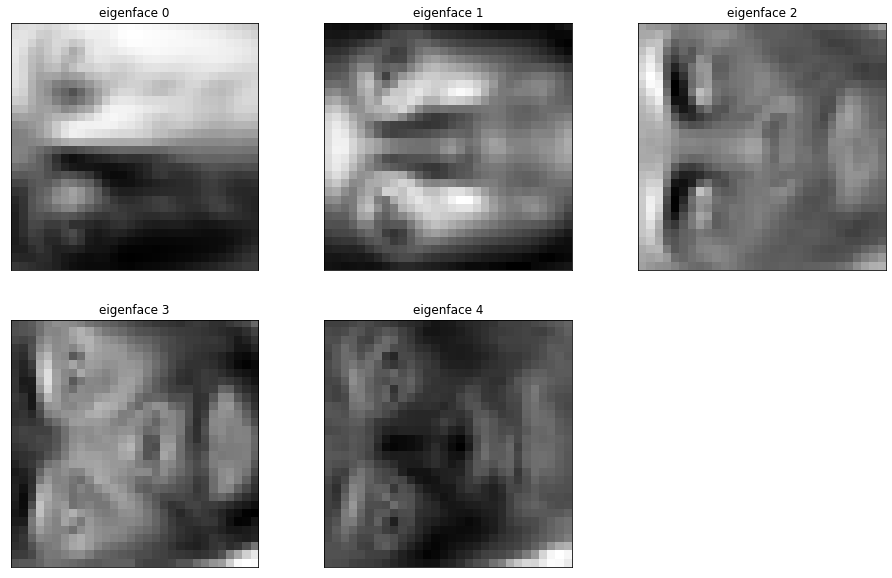

In [45]:
import matplotlib.pyplot as plt

mean_vec = np.mean(Data, axis=0)
centered_data = Data-mean_vec

#using np.linalg.svd(singlular value decomposition to generate eigen faces)
U, S, V = np.linalg.svd(centered_data)
eigen_faces = V[:5].reshape((5,30,30))

eigenface_titles = ["eigenface %d" % i for i in range(eigen_faces.shape[0])]

#plotting eigen faces
plt.figure(figsize=(4.2 * 3, 4.2 * 2))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
for i in range(5):
      plt.subplot(2, 3, i + 1)
      plt.imshow(eigen_faces[i], cmap=plt.cm.gray)
      plt.title(eigenface_titles[i])
      plt.xticks(())
      plt.yticks(())

# Q2

In [104]:
from scipy.io import loadmat
D = loadmat("/content/Code&Data/Abalone.mat")

In [105]:
labels = D['label_vector']   # labels = age values
data = D['instance_matrix'].toarray()   #input features

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(data, labels, test_size=0.5, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=1)   #splitting into train,test and validation set

In [107]:
print("Length of train set:",len(X_train))
print("Length of validation set:",len(X_val))
print("Length of test set:",len(X_test))

Length of train set: 2088
Length of validation set: 836
Length of test set: 1253


In [108]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error

# Using Linear regression to predict the values
L_reg = LinearRegression()
L_reg.fit(X_train,y_train)

print("Train Mean Squared Error:",mean_squared_error(y_train,L_reg.predict(X_train)))
print("Test Mean Squared Error:: ",mean_squared_error(y_test,L_reg.predict(X_test)))
print("Validation Mean Squared Error:",mean_squared_error(y_val,L_reg.predict(X_val)))

Train Mean Squared Error: 4.773808603984102
Test Mean Squared Error::  5.358162932581064
Validation Mean Squared Error: 4.564933800320933


In [109]:
print("Test Mean Squared Error:: ",mean_squared_error(y_test,L_reg.predict(X_test)))

Test Mean Squared Error::  5.358162932581064


In [141]:
val_mse = []

all_alphas = []
beta = []
#starting value of alpha = 10^(-4)
alpha = 10**(-4)

#ending value of alpha = 10^4
while alpha < 10**5:
  all_alphas.append(alpha)
  R_reg = Ridge(alpha = alpha)
  R_reg.fit(X_train,y_train)

  # recording beta for different values of alpha
  beta.append(R_reg.coef_)
  # recording mean squared error for different values of alpha
  val_mse.append([alpha,mean_squared_error(y_val,R_reg.predict(X_val))])
  alpha*=10

In [125]:
sorted(val_mse,key = lambda x:x[1])  # different validation mse for different values of alpha 

[[0.0001, 4.564951179057885],
 [0.001, 4.56510816340551],
 [0.01, 4.566731642341755],
 [0.1, 4.586012519920947],
 [1.0, 4.746072512688645],
 [10.0, 5.530356950917623],
 [100.0, 6.7723963289758755],
 [1000.0, 7.751449692871668],
 [10000.0, 9.397653761279683]]

In [126]:
# alpha=0.0001 has the least mse
R_reg = Ridge(alpha = 0.0001)
R_reg.fit(X_train,y_train)
print("Test Mean Squared error for alpha : 0.0001: ",mean_squared_error(y_test,L_reg.predict(X_test)))

Test Mean Squared error for alpha : 0.0001:  5.358162932581064


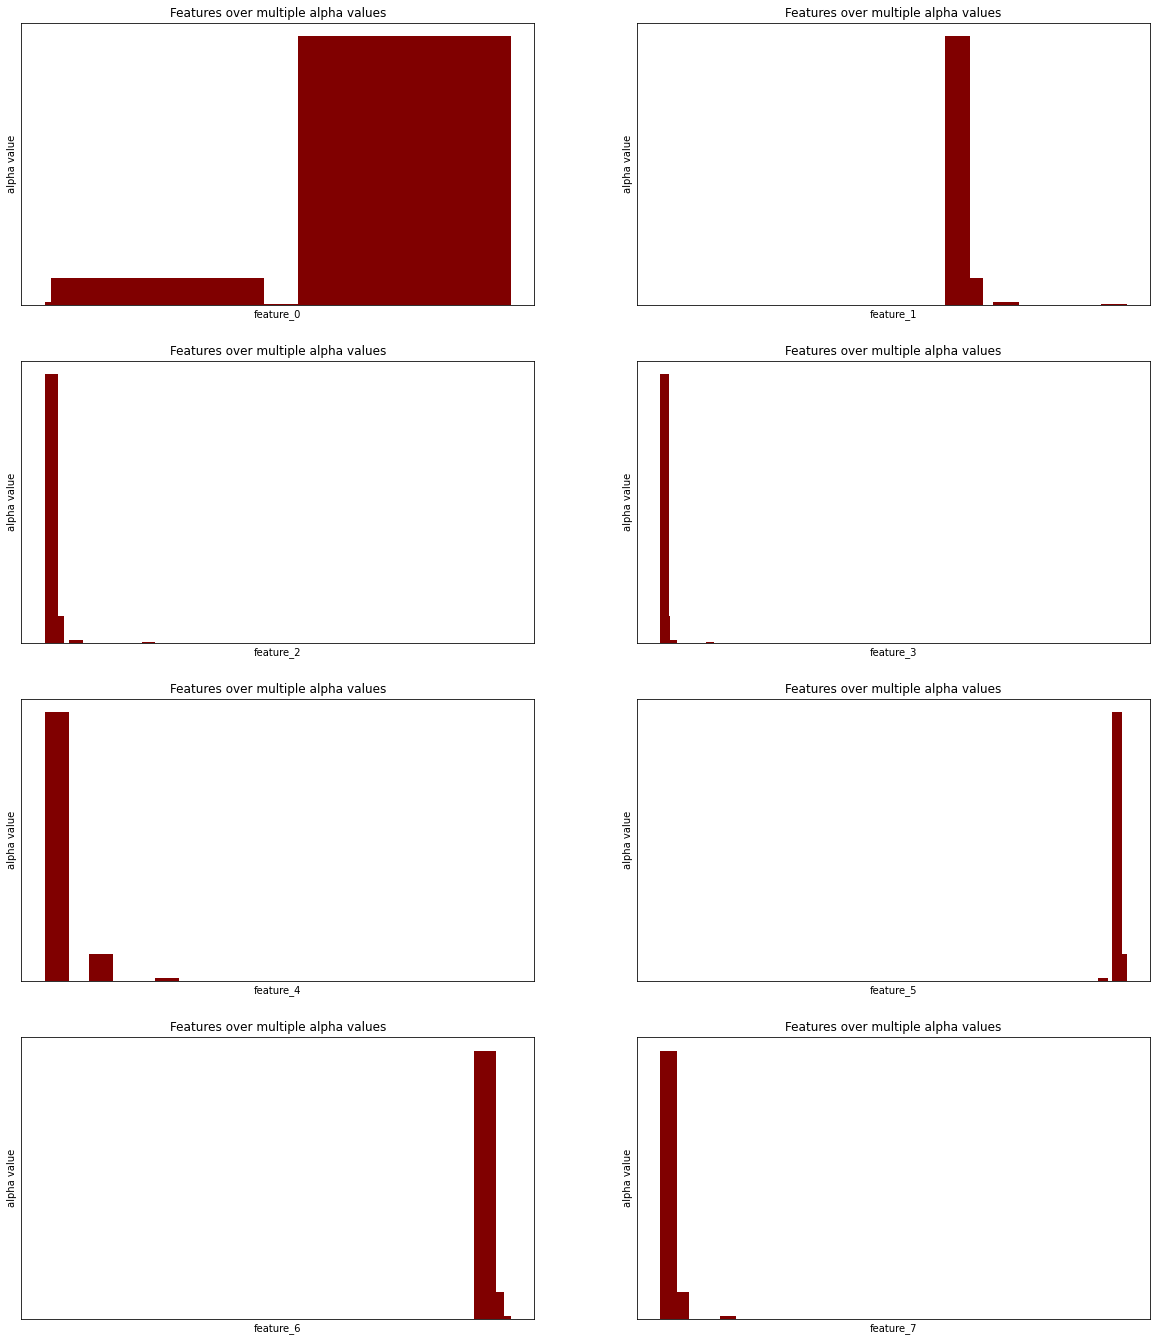

In [155]:

# visualize different beta using bar graph when given different alpha
plt.figure(figsize=(4 * 4, 10 * 2))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)

for i in range(8):
      plt.subplot(4, 2, i + 1)
      lis = [j[0][i] for j in beta]
      plt.bar(lis,all_alphas, color ='maroon',width = 0.4)
      plt.xlabel("feature_"+str(i))
      plt.ylabel("alpha value")
      plt.title("Features over multiple alpha values")
      plt.xticks(())
      plt.yticks(())